# Finance 5330 - Midterm Replication Project
## Jared Hansen, A01439768

## Import statements, set seed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
import scipy.stats as stats
import math
import random
import statsmodels
from statsmodels.tsa.stattools import adfuller
from sklearn import linear_model

USA=1776
random.seed(USA)
np.random.seed(USA)

C:\Users\jrdha\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data Pre-Processing

In [2]:
# NOTE: will want to just zip the data with ipynb file for final product.
# Read in the data
data = pd.read_csv('WaterStocksAdj.csv', parse_dates=True)

#Let's rename the columns for easier access to the data
data.columns = ['Date', 'CTWS', 'WTR', 'AWR']

# Subset to just the CTWS, WTR, and AWR series, keeping the Data column with each series
ctws = data[['Date','CTWS']]
wtr = data[['Date','WTR']]
awr = data[['Date','AWR']]

,Date,AWR
0,1997-01-02,7.291667
1,1997-01-03,7.291667
2,1997-01-06,7.333333
3,1997-01-07,7.333333
4,1997-01-08,7.416667


Let's make sure that the code ran correctly, and take a look at the first few observations in each series.

In [3]:
ctws.head()

,Date,CTWS
0,1997-01-02,13.000000
1,1997-01-03,13.000000
2,1997-01-06,13.000000
3,1997-01-07,13.222222
4,1997-01-08,13.333333


In [4]:
wtr.head()

,Date,WTR
0,1997-01-02,4.492811
1,1997-01-03,4.665612
2,1997-01-06,4.636812
3,1997-01-07,4.608011
4,1997-01-08,4.636812


In [5]:
awr.head()

,Date,AWR
0,1997-01-02,7.291667
1,1997-01-03,7.291667
2,1997-01-06,7.333333
3,1997-01-07,7.333333
4,1997-01-08,7.416667


# Exhibit 1: Descriptive Statistics

In [6]:
def describe_series(data_frame, ticker_name):
    """
    This function takes a series and computes and returns descriptive stats
    about daily log returns (pctg).
    
    Parameters
    ----------
    data_frame : pandas dataframe
        This contains the original data for each stock (has all columns)
    ticker_name : string
        The name of the ticker ('CTWS,'WTR', 'AWR')
        
    Returns
    -------
    Nothing. (Just prints descriptive statistics.)
    """
    
    # Calculating daily log returns (in terms of percentages)
    numer_returns = (np.log(np.absolute(data_frame[ticker_name])).diff(1)[1:])
    denom_returns = (np.log(np.absolute(data_frame[ticker_name]))[0:-1])
    daily_returns = 100 * (np.array(numer_returns)/np.array(denom_returns))
    
    # These are the statistical descriptions for daily returns (pctg)
    daily_returns_descr = stats.describe(daily_returns)
    
    # Display these quantities
    print("Daily returns description for ", ticker_name, " :\n",
          daily_returns_descr, "\n", sep = "")

$\textbf{Descriptive statistics for the CTWS (Connecticut Water Service Inc.) stock from 01-02-1997 to 12-31-2008}$

In [7]:
describe_series(ctws, 'CTWS')

Daily returns description for CTWS :
DescribeResult(nobs=3019, minmax=(-4.369510557505775, 4.4378963750635325), mean=0.009307318689215681, variance=0.47638782810324853, skewness=0.22130118705427318, kurtosis=4.4761956410521035)



$\textbf{Descriptive statistics for the WTR (Aqua America Inc.) stock from 01-02-1997 to 12-31-2008}$

In [8]:
describe_series(wtr, 'WTR')

Daily returns description for WTR :
DescribeResult(nobs=3019, minmax=(-5.705145174294001, 6.815026397407055), mean=0.02468546292693864, variance=0.8111687025728709, skewness=0.43506663382355143, kurtosis=5.164252586996859)



$\textbf{Descriptive statistics for the AWR (American States Water Company) stock from 01-02-1997 to 12-31-2008}$

In [9]:
describe_series(awr, 'AWR')

Daily returns description for AWR :
DescribeResult(nobs=3019, minmax=(-3.64103548630856, 3.8923615388563753), mean=0.01465007656892945, variance=0.6505759517743028, skewness=0.03506757637442587, kurtosis=2.4359303944752115)



# Exhibit 1.5: Visualizing the Series and Returns

### The paper doesn't do this, but I thought it would be a nice complementary piece in our data analysis. Doing some basic visualization is a great place to start in many cases, and we can make sure that the quality of our data is reasonable.

First we'll need to create the log returns for the three series using the function defined below.

In [11]:
def log_returns(orig_data, ticker_name):
    """
    This function takes the orig_data (pandas dataframe with all the data for
    each stock) and creates a first-differenced series of log daily returns.
    
    Parameters
    ----------
    orig_data : pandas dataframe
        This contains the original data for each stock (has all columns)    
    ticker_name : string
        The name of the ticker ('CTWS,'WTR', 'AWR')
        
    Returns
    -------
    log_rtns : pandas time series
        This is a pandas series (contains only daily log returns for the
        closing price, PRC, column)
    """
    # Calculating daily log returns (in terms of percentages)
    numer_returns = (np.log(np.absolute(orig_data[ticker_name])).diff(1)[1:])
    denom_returns = (np.log(np.absolute(orig_data[ticker_name]))[0:-1])
    log_rtns = 100 * (np.array(numer_returns)/np.array(denom_returns))
    
    return pd.Series(log_rtns)

# Create the daily log returns for all 3 series
ctws_log_rtns = log_returns(ctws, 'CTWS')
wtr_log_rtns = log_returns(wtr, 'WTR')
awr_log_rtns = log_returns(awr, 'AWR')

Now let's plot a histogram for each of the three series.
In doing so, we'll observe that the distributions are centered about 0 and look to be somewhat normal. However we also see the thick tails (i.e. extreme returns) characteristic of financial return data, especially for the CTWS ticker.

Text(0.5, 1.0, 'CTWS log returns distribution')

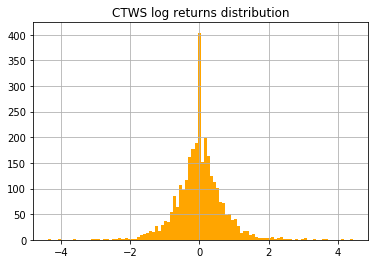

In [12]:
ctws_log_rtns.hist(bins=100, color="orange", label='CTWS log returns');
plt.title("CTWS log returns distribution")

Text(0.5, 1.0, 'WTR log returns distribution')

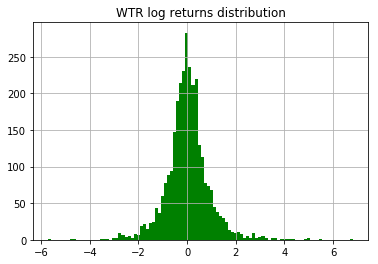

In [13]:
wtr_log_rtns.hist(bins=100, color="green");
plt.title("WTR log returns distribution")

Text(0.5, 1.0, 'AWR log returns distribution')

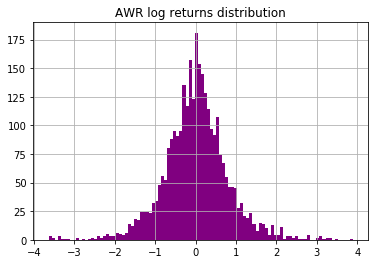

In [14]:
awr_log_rtns.hist(bins=100, color="purple");
plt.title("AWR log returns distribution")

Now let's plot the prices of the three series over time together for a cursory visual inspection. We would expect that they appear to move with each other, exhibiting co-integrated behavior between the pairs.

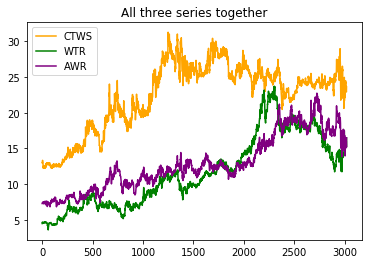

In [32]:
plt.plot(ctws['CTWS'], label='CTWS', linewidth=1.5, color='orange');
plt.plot(wtr['WTR'], label='WTR', linewidth=1.5, color='green');
plt.plot(awr['AWR'], label="AWR", linewidth=1.5, color='purple');
plt.title("All three series together")
plt.legend()
plt.show()

# Exhibit 2: Integration and Co-integration

$\textbf{Panel A: Augmented Dickey-Fuller Test for integration}$  

First let's write code to generate the data we need:
- the daily closing log price series for each stock
- the first-differenced daily closing log price series for each stock (we have to exclude the first element due to the differencing)

In [16]:
# Create the daily closing log price series for each stock.
ctws_log_prcs = (np.log(np.absolute(ctws["CTWS"])))
wtr_log_prcs = (np.log(np.absolute(wtr["WTR"])))
awr_log_prcs = (np.log(np.absolute(awr["AWR"])))

# Create the first-differenced daily closing log price series for each stock.
# (Since we're doing first-differencing, we have to exclude the first element
#  because it's just a missing value.)
ctws_log_prcs_diff1 = (np.log(np.absolute(ctws["CTWS"]))).diff(1)[1:]
wtr_log_prcs_diff1 = (np.log(np.absolute(wtr["WTR"]))).diff(1)[1:]
awr_log_prcs_diff1 = (np.log(np.absolute(awr["AWR"]))).diff(1)[1:]

Next let's carry out the ADF test for each of these series to generate the 'Levels' and 'Differences' values to populate $\textbf{Panel A}$

In [17]:
# ADF test for daily closing log price for the orginal 3 series (NOT differenced).
# This is creating the 'Levels' line of the chart in Panel A
adf_ctws_log_prcs = adfuller(x=ctws_log_prcs, maxlag = 10, regression = "nc", autolag="BIC")
adf_ctws_log_prcs
adf_wtr_log_prcs = adfuller(x=wtr_log_prcs, maxlag = 10, regression = "nc", autolag="BIC")
adf_wtr_log_prcs
adf_awr_log_prcs = adfuller(x=awr_log_prcs, maxlag = 10, regression = "nc", autolag="BIC")
adf_awr_log_prcs

# ADF test for daily closing log price first differences for the 3 series.
# This is creating the 'First difference' line of the chart in Panel A
adf_ctws_log_prcs_diff1 = adfuller(x=ctws_log_prcs_diff1, maxlag = 10, regression = "nc", autolag="BIC")
adf_ctws_log_prcs_diff1
adf_wtr_log_prcs_diff1 = adfuller(x=wtr_log_prcs_diff1, maxlag = 10, regression = "nc", autolag="BIC")
adf_wtr_log_prcs_diff1
adf_awr_log_prcs_diff1 = adfuller(x=awr_log_prcs_diff1, maxlag = 10, regression = "nc", autolag="BIC")
adf_awr_log_prcs_diff1

(-58.82274200999155,
 0.0,
 0,
 3018,
 {'1%': -2.5664812199434275,
  '5%': -1.9410893676437517,
  '10%': -1.6167322917449751},
 -14941.774246824032)

$\textbf{NOTE:}$ See markdown cell above for code used to generate ADF test results.

$\textbf{PANEL A: Augmented Dickey-Fuller Test for integration}$

|              .| CTWS                           | WTR                            | AWR                             | 
|---------------|--------------------------------|--------------------------------|---------------------------------|
| Levels        | test_stat=0.508, p=0.827       | test_stat=0.872, p=0.897       | test_stat=0.539, p=0.834        |
| First-diffed  | test_stat= -47.06, p$\approx$0 | test_stat= -54.93, p$\approx$0 | test_stat= -58.82, p$\approx$0  |

Based on the 'Levels' results we can see that the three series are all non-stationary (we don't come even close to rejecting $H_0$: presence of unit-root). After first-differencing we then have stationary series (hence the miniscule p-values, rejecting the unit-root $H_0$), implying that the original log-value price series are all $I(1)$. 

$\textbf{Panel B: Augmented Dickey-Fuller Test for co-integration}$  

First let's plan out how we'll implement the Engle-Granger (two-step) method:
- First, test for co-integration by submitting $\hat{\epsilon_t}$ to the ADF test. What do you find?
- Obtain $\hat{\beta}$ via OLS regression.
- Estimate the error-correction model with p=1 and include contemporaneou $x_t$.

In [20]:
def adf_twoSeries(regressor, regressand):
    """
    This function performs the ADF test for two time series, determining if
    they are co-integrated.
    We test for co-integration by submitting the epsilon-hat terms (of the 
    regression of the two series) to the ADF test.
    
    Parameters
    ----------
    regressor : pandas series
        This is the "predictor" variable series.
    regressand : pandas series
        This is the "dependent/response" variable series.
        
    Returns
    -------
    adf_results : tuple
        The ADF test results for the two given series.
    """
    # Regress the regressand (response:y) on the regressor (predictor:x)
    reg = stats.linregress(regressor, regressand)
    # Residuals eps (typically epsilon) --> y_hat = m(x) + b
    # --> eps = y_1 - y_1_hat = y_1 - m(x_1) + b
    eps = regressand - reg.slope*regressor - reg.intercept 
    
    # Submit eps to the ADF test
    adf_eps = adfuller(x=eps, maxlag = 10, regression = "nc", autolag="BIC")
    
    # A small p-value ==> no presence of unit-root in epsilon series    
    return adf_eps


# Create the series, removing the indexing (and date since their dates are
# identical)
awr_log_prcs = awr_log_prcs.reset_index(drop=True)
ctws_log_prcs = ctws_log_prcs.reset_index(drop=True)
wtr_log_prcs = wtr_log_prcs.reset_index(drop=True)

Now let's perform the ADF test for co-integration for the desired pairs

In [21]:
adf_ctws_wtr = adf_twoSeries(regressor=ctws_log_prcs,
                             regressand=wtr_log_prcs)
adf_ctws_wtr

(-2.1551555045505872,
 0.029896462172730197,
 2,
 3017,
 {'1%': -2.5664814657565804,
  '5%': -1.9410893973868528,
  '10%': -1.616732262771812},
 -12332.977583644872)

In [22]:
adf_wtr_awr = adf_twoSeries(regressor=wtr_log_prcs,
                            regressand=awr_log_prcs)
adf_wtr_awr

(-3.9327626150041355,
 9.537188490965299e-05,
 1,
 3018,
 {'1%': -2.5664812199434275,
  '5%': -1.9410893676437517,
  '10%': -1.6167322917449751},
 -15111.863161592843)

In [23]:
adf_ctws_awr = adf_twoSeries(regressor=ctws_log_prcs,
                             regressand=awr_log_prcs)
adf_ctws_awr

(-2.389272213825196,
 0.016277300821825862,
 2,
 3017,
 {'1%': -2.5664814657565804,
  '5%': -1.9410893973868528,
  '10%': -1.616732262771812},
 -14038.983926052704)

$\textbf{NOTE:}$ See markdown cells above for code used to generate ADF test results.

$\textbf{PANEL B: Augmented Dickey-Fuller Test for co-integration}$

|          .| Regressand                    | Regressand                     | Regressand                      |
|-----------|-------------------------------|--------------------------------|---------------------------------|
| Regressor | WTR                           | AWR                            | AWR                             | 
| CTWS      | test_stat= -2.15, p=0.0299    |                               .| test_stat= -2.389, p=0.0163     |
| WTR       |                              .| test_stat= -3.933, p$\approx$0 |                                .|

Based on these results we can conclude that these pairs are all co-integrated. The low p-values imply rejection of [$H_0$: there exists no co-integration] if using $\alpha = 0.05$ as our significance level. In other words, for these individual $I(1)$ series pairs there exists some linear combination such that the residuals are found to be stationary ($I(0)$).

# Dr. Brough modification: Implementing the Trading Strategy

The most efficient way that I found to implement the trading strategy described in the paper was to generate two classes:
- the $\textbf{'GenerateInfo'}$ class. This class generates information for a given pair of log stock price series, including:
    - predicted values of the Granger-caused series
    - differences between these predicted values and the actual values (I call this array of floating-point numbers 'diffs')
    - upper and lower bound values around the 0-line for these differences, which creates a band I call "the equilibrium zone'
    - a list of strings indicating whether or not the actual differences are within, above, or below the equilibrium zone (I call this list of strings 'equilibs')
    - Also, this class has a method to generate a graphic representation of this information (plots the equilibrium zone and the diffs array, showing where diffs moves outside of the equilibrium zone and crosses the 0-line to create trading signals).
- the $\textbf{'NumSignals'}$ class. This class does the heavy lifting of implementing the trading rule to:
    - determine how many trades are made ('num_buys' and 'num_sells') based on the rule given in the paper
    - how long the first buy and sell trade signal positions are held
    - the return of the first buy and sell trade positions for each of the three pairs being considered
    
These classes are defined in the code cell below.

In [33]:
class GenerateInfo:
    """
    This class generates information for a given pair of log stock price
    series, including: predicted values of the Granger-causes series,
    differences between these predicted values and the actual values, upper and
    lower bound values around the 0-line for these differences, and a list of
    strings indicating whether or not the actual differences are within, above,
    or below the calculated boundaries.
    Also, this class has a method to generate a graphic representation of this 
    information.    
    """
    def __init__(self, log_prcs_series1, log_prcs_series2, delta_i,
                 regr_x_name, regd_y_name, delta_i_str):
        '''
        The constructor takes two logged series (series1 is the regressor and
        series2 is the regressand), the delta_i value used to determine the 
        width of the equilibrium zone, and strings of these argument names to
        create well-labeled graphics.
        Parameters 
        ----------
        log_prcs_series1 : Pandas series
            Log-values of one of the CTWS, WTR, or AWR series (regressor)
        log_prcs_series2 : Pandas series
            Log-values of one of the CTWS, WTR, or AWR series (regressand)
        delta_i : float
            Is one of {0.25, 0.5, 0.75}, used to determine the width of the
            equilibrium zone about the 0-line.
        regr_x_name : string
            the name (CTWS, WTR, AWR) of the regressor series, used to label
            the plot
        regd_y_name: string
            the name (CTWS, WTR, AWR) of the regressand series, used to label
            the plot
        delta_i_str : string
            the delta_i value as a string ('0.25', '0.5', '0.75') used for 
            labeling the plot
        '''
        self.log_prcs_series1 = log_prcs_series1
        self.log_prcs_series2 = log_prcs_series2
        self.delta_i = delta_i
        self.regr_x_name = regr_x_name
        self.regd_y_name = regd_y_name
        self.delta_i_str = delta_i_str
            
        
        
    def calc_preds_eps_diffs_bounds(self):
        '''
        This function calculates
        - predicted log prices of the Granger-caused series
        - epsilons (errors) of the predicted series
        - diffs between the predicted series VS actual values of the series
        - the upper and lower bounds of the equilibrium zone
        
        Parameters
        ----------
        self
            
        Returns
        -------
        calcs : tuple (series of floats, float, float)
            This tuple has the diffs series, the lowerb of eq-zone, and the
            upperb of the eq-zone respectively
        '''
        # Estimating equation 6 from the paper:
        # log(y_series) = alpha + beta_1(log(x_series)) + epsilon
        x_regr = self.log_prcs_series1
        y_regd = self.log_prcs_series2
        delta_i = self.delta_i
        # Regress the Granger-caused series on the predictor series, extract
        # and store relevant values from the regression.
        reg_y_on_x = stats.linregress(x = x_regr, y = y_regd)
        alpha = reg_y_on_x.intercept
        alpha
        beta_1 = reg_y_on_x.slope
        beta_1
        # Generate the series of error terms.
        eps_y_on_x = y_regd - beta_1*x_regr - alpha
        # Calculate the standard deviation of the residuals
        sigma_eps = np.std(eps_y_on_x)
        # Now doing the stuff for equation 7:
        pred_log_y = alpha + beta_1*(x_regr)
        # Now doing the stuff for equation 8:
        # Determine difference between fitted values and the actual values:
        diffs = y_regd - pred_log_y
        # Upper bound for the trading rule:
        upperb = 1.0 * (delta_i * sigma_eps)
        # Lower bound for the trading rule:
        lowerb = -1.0 * (delta_i * sigma_eps)
        # Store the things we need for further calculations in a tuple, return
        calcs = (diffs, lowerb, upperb)
        return calcs



    def gen_plot(self):
        '''
        This function generates the plot showing the difference series between
        the actual log prices and the predicted log prices. Also gives the
        equilibrium zone (dashed line that determines half1 of trade signals).
        
        Parameters
        ----------
        self
            
        Returns
        -------
        Nothing; creates the desired plot
        '''
        # Store strings to be used for plot title
        regr_x_name = self.regr_x_name
        regd_y_name = self.regd_y_name
        delta_i_str = self.delta_i_str
        # Call the function to calculate the diffs, lowerb, and upperb
        calcs = self.calc_preds_eps_diffs_bounds()
        # Plot the diffs series
        plt.plot(calcs[0], color='blue');
        # Create the zero line (perfect equilibrium btwn prediction and actual)
        plt.axhline(y=0, linewidth=2.0, color='black')
        # Plot the upper bound of the equilibrium zone
        plt.axhline(y= calcs[2], linewidth=2.0, color='red', linestyle='--')
        # Plot the lower bound of the equilibrium zone
        plt.axhline(y= calcs[1], linewidth=2.0, color='red', linestyle='--')
        plt.title("Trading Strategy Plot for x=" + regr_x_name + ", y=" +
                  regd_y_name + ", delta_i=" + delta_i_str)
        plt.show()
        
        
        
    def gen_equilib(self):
        '''
        This function takes in the series of differences (between the predicted
        log price and the actual log price) for one of the series. It returns a
        list indicating whether each difference is within the equilibrium zone
        or not.
        
        Parameters
        ----------
        self
    
        Returns
        -------
        equilibs : list (of strings)
            A list where each element is either 'below', 'within', or 'above'
            to indicate whether the error is within the equilibrium zone or not
        '''
        # Call the function to calculate the diffs, lowerb, and upperb
        calcs = self.calc_preds_eps_diffs_bounds()
        diffs = calcs[0]
        lowerb = calcs[1]
        upperb = calcs[2]
        # Initialize an empty list to store values
        equilibs = []
        # Calculate whether each diff value is in or out of the eq-zone.
        for i in range(len(diffs)):
            if(diffs[i] < lowerb): equilibs.append('below')
            elif(diffs[i] > upperb): equilibs.append('above')
            else: equilibs.append('within')
        # Return the list
        return equilibs
            




#--------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------





class NumSignals:
    """
    This class does the heavy lifting of implementing the trading rule to
    determine how many trades are made, how long the first buy and sell trade
    signal positions are held, and the return of the first buy and sell trade
    positions.
    """
    def __init__(self, diffs, equilibs, x_log_prcs, y_log_prcs):
        '''
        Parameters 
        ----------
        diffs : Pandas series
            A series of differences between the predicted log prices of a
            series and the actual log series. Generated using the
            GenerateInfo class.
        equilibs : list
            Elements are strings indicating whether each difference is above,
            below, or within the equilibrium zone). Generated using the
            GenerateInfo class.
        x_log_prcs : Pandas series
            The Granger-causing series (regressor)
        y_log_prcs : Pandas series
            The Granger-caused series (regressand)
        '''
        self.diffs = diffs
        self.equilibs = equilibs
        self.x_log_prcs = x_log_prcs
        self.y_log_prcs = y_log_prcs
        
        
        
    def consider_signal(self, index):
        '''
        This function checks "...if a position is not closed out prior to
        12-31-08 then that position is not considered at all" from the paper.
        Essentially, at the given index does the diffs series not move back
        past 0 to trigger a buy (or sell) position closing out?
        
        Parameters
        ----------
        index : int
            The index at which we're checking if all of the remaining diffs are 
            either 'above' or 'below' the equilibrium zone. If so, we won't 
            count that index as being a trading signal, returning False.
            
        Returns
        -------
        consider : bool
            A boolean value telling whether we should consider this trading
            signal (True) or not consider this trading signal (False).    
        '''
        diffs = self.diffs
        # Check if all of the remaining diffs are above 0. If so, the position
        # doesn't close, and we wont' consider this trading signal.
        if(all(diff > 0 for diff in diffs[index:])):
            consider = False
        # Check if all of the remaining diffs are below 0. If so, the position
        # doesn't close, and we wont' consider this trading signal.      
        elif(all(diff < 0 for diff in diffs[index:])):
            consider = False
        # If all of the remaining diffs weren't all either [>0] or [<0] then
        # we should consider this trading signal.
        else:
            consider = True
        return consider
    
    
    
    def find_half1_trading_signal(self, current_index):
        '''
        This function checks to see if the current_index in the equilibs list
        gives the first half of a trading signal (i.e. moves outside of the
        equilibrium zone). From the paper:
        TRADING RULE
        - if(errors_y < lowerb): then short X and simultaneously long Y.
              Reverse the position once errors_y reverts back up to zero.
        - if(errors_y > upperb): then long X and simultaneously short Y.
              Reverse the position once errors_y reverts back down to zero.
        
        Parameters
        ----------
        current_index : int
            Gives the current index being considered (does that index give the
            first half of a trading signal?)
            
        Returns
        -------
        half1_signal : string
            Either 'buy' or 'sell' depending on whether the values moved below
            or above the equilibrium zone.
        '''
        diffs = self.diffs
        equilibs = self.equilibs
        # Initialize gives_signal
        gives_signal = 'none'
        # Checking  first value in the series for signal, current_index = 0
        if(current_index == 0):
            # Is there a buy signal? If so, is it coming at the end of the
            # time frame and isn't being considered?
            if(equilibs[current_index] == 'below'):
                if(self.consider_signal(current_index)):
                    gives_signal = 'buy'
            elif(equilibs[current_index] == 'above'):
                if(self.consider_signal(current_index)):
                    gives_signal = 'sell'
            else: gives_signal = 'none'
        # For all non-0 indices the immediately-preceding val must be 'within'
        elif(equilibs[current_index-1] == 'within'):
            if(equilibs[current_index] == 'below'):
                if(self.consider_signal(current_index)):
                    gives_signal = 'buy'
            elif(equilibs[current_index] == 'above'):
                if(self.consider_signal(current_index)):
                    gives_signal = 'sell'
            else: gives_signal = 'none'
        # Everything else is a 'none'
        else: gives_signal = 'none'
        return gives_signal
    
    
    
    def find_half2_trading_signal(self, half1, current_index):
        '''
        This function checks to see if the diffs (btwn pred prc and actual prc)
        gives the second half of a trading signal (i.e. moves across zero line)
        From the paper:
        TRADING RULE
        - if(errors_y < lowerb): then short X and simultaneously long Y.
              Reverse the position once errors_y reverts back up to zero.
        - if(errors_y > upperb): then long X and simultaneously short Y.
              Reverse the position once errors_y reverts back down to zero.
        
        Parameters
        ----------
        half1 : string
            Is either 'buy' or 'sell' depending on the first-half of the signal
        current_index : int
            Gives the index being considered (picks up where the half1 of the 
            signal leaves off).
            
        Returns
        -------
        gives_half2 : bool
            Returns True when the function finds the second half of a signal,
            returns False otherwise.
        '''
        diffs = self.diffs
        # Intialize this indicator bool to be False 
        gives_half2 = False
        # If the first half signal was 'buy'
        if(half1 == 'buy'):
            if(diffs[current_index] >= 0):
                gives_half2 = True
        # If the first half signal was 'sell'
        elif(half1 == 'sell'):
            if(diffs[current_index] <= 0):
                gives_half2 = True       
        return gives_half2
    
    
    
    def num_buys_sells(self):
        '''
        This function counts the number of buy signal pairs and sell signal
        pairs. (Since each buy or sell only closes once the diffs move back
        across 0, there is an opening half and a closing half for each signal,
        hence they're a pair).
        
        Parameters
        ----------
        self
            
        Returns
        -------
        num_signals : tuple (int, int)
            Tuple consists of the number of buy signal pairs and sell signal
            pairs (num_buys, num_sells)    
        '''
        # Call the function to calculate the diffs, lowerb, and upperb
        diffs = self.diffs
        # Call the function to calculate the equilibs
        equilibs = self.equilibs
        # Initialize the number of pair signals
        num_buys = 0
        num_sells = 0
        # Set bools to have us start by looking for the first half of a signal.
        looking_half1 = True
        looking_half2 = False
        # looping through the whole series of diffs
        for i in range(len(diffs)):
            # Checking for half1 (based on bool)
            if(looking_half1):
                # Call fctn to see if we get half1 of a signal
                half1 = self.find_half1_trading_signal(i)
                # Go into this if statement once we've found half1 of a signal
                # We need to flip the bools so now we're looking for half2
                if(half1 != 'none'):
                    looking_half1 = False
                    looking_half2 = True    
            # Now we're looking for half2 of the signal once we've found half1.
            if(looking_half2):
                # Call fctn to see if we get half2 of a signal
                half2 = self.find_half2_trading_signal(half1, i)
                # Go into this if statement once we've found half2 of a signal
                # We again need to flip the bools so now we're looking for half1
                # of a signal again.
                if(half2):
                    looking_half1 = True
                    looking_half2 = False
                    # If we have a buy, increment num_buys by 1, else num_sells 
                    if(half1 == 'buy'):
                        num_buys += 1
                    elif(half1 == 'sell'): 
                        num_sells += 1
        # Return a tuple containing the number of buys and sells.
        num_signals = (num_buys, num_sells)
        return num_signals


        
    def find_signal_indices(self, signal_type):
        """
        This function finds the indices for the opening and closing of a 
        'signal_type' position (e.g. finds the index of the opening of the
        first buy position and finds the corresponding index of the closing of
        the first buy position).
        
        Parameters
        ----------
        signal_type : string
            Either 'buy' or 'sell'
            
        Returns
        -------
        tuple : (string, int, int)
            First element string is just the signal_type ('buy' or 'sell'), the
            first int is the index of the position opening, the second int is
            the index of the position closing.
        """
        # Call the function to calculate the diffs, lowerb, and upperb
        diffs = self.diffs
        # Call the function to calculate the equilibs
        equilibs = self.equilibs
        # Initialize the indices of the position open and close
        half1_index = 0
        half2_index = 0
        # Set bools to have us start by looking for the first half of a signal.
        looking_half1 = True
        looking_half2 = False
        # Set a bool to indicate whether we've found the first pair of the
        # desired signal_type yet
        found_pair = False
        # looping through the whole series of diffs
        for i in range(len(diffs)):
            # Checking for half1 (based on bool)
            if(looking_half1):
                # Call fctn to see if we get half1 of a signal
                half1 = self.find_half1_trading_signal(i)
                # Go into this if statement once we've found half1 of a signal
                # We need to flip the bools so now we're looking for half2
                if(half1 == signal_type):
                    looking_half1 = False
                    looking_half2 = True 
                    half1_index = i                    
            # Now we're looking for half2 of the signal once we've found half1.
            if(looking_half2):
                # Call fctn to see if we get half2 of a signal
                half2 = self.find_half2_trading_signal(signal_type, i)
                # Go into this if statement once we've found half2 of a signal
                # We again need to flip the bools so now we're looking for half1
                # of a signal again.
                if(half2):
                    half2_index = i
                    break
        # Return a tuple containing the number of buys and sells.
        signal_info = (half1, half1_index, half2_index)
        return signal_info
    
    
    def calc_return(self, signal_type):
        """
        This function calculates the return of a trading position (either the
        first buy or the first sell).
        
        Parameters
        ----------
        signal_type : string
            Is either 'buy' or 'sell', the type of signal for which we
            calculate the return of the first signal.
        
        Returns
        -------
        pct_return : float
            This is the percent return using the log prices of the CTWS
            (regressor) series and log prices of the WTR (regressand) series.
        """
        # Find the indices pair for the signal
        inds = self.find_signal_indices(signal_type)
        # Follow the trading rule outlined in the paper, calculating the
        # returns for both the short and long positions, then add them.
        if(signal_type == 'buy'):
            short_return = (self.x_log_prcs[inds[1]] - self.x_log_prcs[inds[2]])/self.x_log_prcs[inds[1]]
            long_return = (self.y_log_prcs[inds[2]] - self.y_log_prcs[inds[1]])/self.y_log_prcs[inds[1]]
        else :
            short_return = (self.y_log_prcs[inds[1]] - self.y_log_prcs[inds[2]])/self.y_log_prcs[inds[1]]
            long_return = (self.x_log_prcs[inds[2]] - self.x_log_prcs[inds[1]])/self.x_log_prcs[inds[1]]
        total_return = 100 * (short_return + long_return)
        return total_return

Before moving on to calculations and plotting, let me answer the question of what a $\textit{buy signal}$ and a $\textit{sell signal}$ are in the context of pairs trading, and how I implement them in my coding. 

Referring to the TRADING RULE section on page 55 of THE JOURNAL OF TRADING, Spring 2011 edition we see the following:
- if $\textit{diff}$ < $\textit{lowerBound}$ then short CTWS and simultaneoulsy long WTR....The entire position is reversed once $\textit{diff}$ reverts back up to zero. If a position is not closed out prior to December 31, 2008, then that position is not considered at all.
- if $\textit{diff}$ > $\textit{upperBound}$ then long CTWS and simultaneoulsy short WTR....The entire position is reversed once $\textit{diff}$ reverts back down to zero. If a position is not closed out prior to December 31, 2008, then that position is not considered at all.

Before giving my explanation, note that I used the ter 'equilibrium zone' to mean the range of $\textit{diff}$ values that starts at the $\textit{lowerBound}$ and extends up to the $\textit{upperBound}$ centered about the 0-line.

The intuition behind this trading rule is that the system (the relationship between the prices of these pairs of stocks) can move into dis-equilibrium but must move back to equilibrium in a predictable way due to their co-integrated relationship. The quantitative realization of this intution is the (vector) error-correction model: here the 'diffs' I calculate are the errors being corrected (hence the name). I implement all of this in the $\textit{calc_preds_eps_diffs_bounds}$ method in the $\textit{GenerateInfo}$ class: equations 6, 7, and 8 from the paper are used to calculate the actual relationship between the two series, the predicted relationship between the two series (based on co-integration), and the difference between these two calculations. These differences, and the variation within them, are what define the equilibrium zone and illusrate when the system (system of relative prices) is moving out of equilibrium (e.g. moves below or above the lower bound of the equilibrium zone). When we see that the system is moving out of equilibrium it gives us a signal that one of the series has to move back upward (we long that stock) and the other has to move back downward (we short that stock) depending on which series is the regressand ("Granger-caused") and which series is the regressor ("Granger-causing"), and whether the 'diffs' moved above or below the equilibrium zone. Then once the system "reverts back to zero" the system of relative prices has moved back into equilibrium; thus we reverse our positions since the system has corrected itself and that specific $\textbf{ARBITRAGE OPPORTUNITY}$ has concluded, with more to come along in the future.

In essence, this pairs trading strategy is taking advantage of a very well-define $\textit{arbitrage recipe}$ for a system of relative prices with predictable, co-integrated behavior. Also, it must be made clear that a single 'buy signal' or a 'sell signal' is composed of an opening half (moving out of eq-zone and going long on one stock and short on the other) and a closing half (crossing back over the 0-line and reversing the long/short positions).  
Understanding this [opening signal, closing signal] = [one signal] took me some time to realize and was not trivial to implement in code.

Now that we have defined what a buy/sell signal is and implemented the necessary classes above let's use them to complete the remaining tasks in the project.  
First lets:
- plot the time series graph showing the 'diffs' array along with the 'equilibrium zone' for a given pair of stocks and all possible $\delta_i \in \{0.25, 0.5, 0.75\}$ values
- calculate the number of buy and sell signals for each trading rule
- summarize these results in a table (one table for each pair of stocks)

After having done this for each pair of stocks and $\delta$ values I will:
- identify the first buy signal and first sell signal for each pair using the $\delta_1 = 0.25$ trading rule, calculating how many days each position is held for, and calculating the return on the trades

### For the pair $\textbf{x = CTWS}$ and $\textbf{y = WTR}$ with $\delta_i \in \{0.25,0.5,0.75\}$:

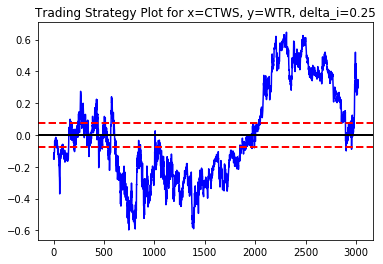

num_buys: 12
num_sells: 14


In [26]:
# Use the GenerateInfo class to generate equilibs and diffs
xCTWS_yWTR_25 = GenerateInfo(ctws_log_prcs, wtr_log_prcs, 0.25, "CTWS", "WTR", "0.25")
xCTWS_yWTR_25_equilibs = xCTWS_yWTR_25.gen_equilib()
xCTWS_yWTR_25_diffs = xCTWS_yWTR_25.calc_preds_eps_diffs_bounds()[0]
# Use the NumSignals class to calculate the number of pairs of buy signals and
# the number of pairs of trade signals. Also plot the figure.
xCTWS_yWTR_25_signals = NumSignals(xCTWS_yWTR_25_diffs, xCTWS_yWTR_25_equilibs, ctws_log_prcs, wtr_log_prcs)
xCTWS_yWTR_25.gen_plot()
print("num_buys:", xCTWS_yWTR_25_signals.num_buys_sells()[0])
print("num_sells:", xCTWS_yWTR_25_signals.num_buys_sells()[1])

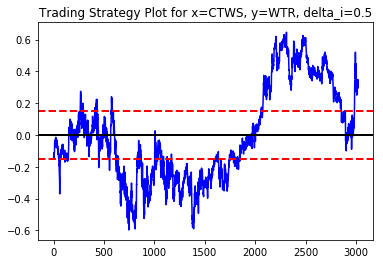

num_buys: 5
num_sells: 4


In [27]:
# Use the GenerateInfo class to generate equilibs and diffs
xCTWS_yWTR_5 = GenerateInfo(ctws_log_prcs, wtr_log_prcs, 0.5, "CTWS", "WTR", "0.5")
xCTWS_yWTR_5_equilibs = xCTWS_yWTR_5.gen_equilib()
xCTWS_yWTR_5_diffs = xCTWS_yWTR_5.calc_preds_eps_diffs_bounds()[0]
# Use the NumSignals class to calculate the number of pairs of buy signals and
# the number of pairs of trade signals. Also plot the figure.
xCTWS_yWTR_5_signals = NumSignals(xCTWS_yWTR_5_diffs, xCTWS_yWTR_5_equilibs, ctws_log_prcs, wtr_log_prcs)
xCTWS_yWTR_5.gen_plot()
print("num_buys:", xCTWS_yWTR_5_signals.num_buys_sells()[0])
print("num_sells:", xCTWS_yWTR_5_signals.num_buys_sells()[1])

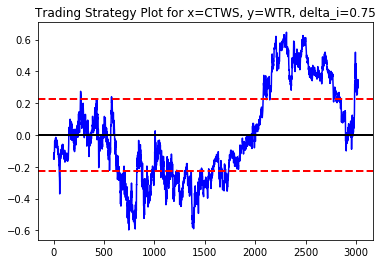

num_buys: 3
num_sells: 4


In [28]:
#------ [x=CTWS] + [y=WTR] + [delta_i = 0.75] ---------------------------------
# Use the GenerateInfo class to generate equilibs and diffs
xCTWS_yWTR_75 = GenerateInfo(ctws_log_prcs, wtr_log_prcs, 0.75, "CTWS", "WTR", "0.75")
xCTWS_yWTR_75_equilibs = xCTWS_yWTR_75.gen_equilib()
xCTWS_yWTR_75_diffs = xCTWS_yWTR_75.calc_preds_eps_diffs_bounds()[0]
# Use the NumSignals class to calculate the number of pairs of buy signals and
# the number of pairs of trade signals. Also plot the figure.
xCTWS_yWTR_75_signals = NumSignals(xCTWS_yWTR_75_diffs, xCTWS_yWTR_75_equilibs,  ctws_log_prcs, wtr_log_prcs)
xCTWS_yWTR_75.gen_plot()
print("num_buys:", xCTWS_yWTR_75_signals.num_buys_sells()[0])
print("num_sells:", xCTWS_yWTR_75_signals.num_buys_sells()[1])

### For the pair $\textbf{x = CTWS}$ and $\textbf{y = WTR}$:

| $\delta_i$ | num_buys | num_sells |
|------------|----------|-----------|
| 0.25       | 12       | 14        |
| 0.5        | 5        | 4         |
| 0.75       | 3        | 4         |

### For the pair $\textbf{x = WTR}$ and $\textbf{y = AWR}$ with $\delta_i \in \{0.25,0.5,0.75\}$:

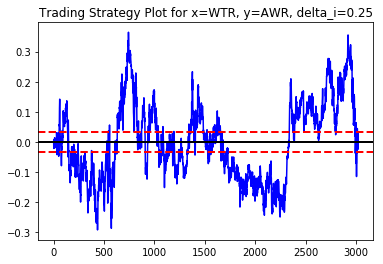

num_buys: 24
num_sells: 25


In [29]:
# Use the GenerateInfo class to generate equilibs and diffs
xWTR_yAWR_25 = GenerateInfo(wtr_log_prcs, awr_log_prcs, 0.25, "WTR", "AWR", "0.25")
xWTR_yAWR_25_equilibs = xWTR_yAWR_25.gen_equilib()
xWTR_yAWR_25_diffs = xWTR_yAWR_25.calc_preds_eps_diffs_bounds()[0]
# Use the NumSignals class to calculate the number of pairs of buy signals and
# the number of pairs of trade signals. Also plot the figure.
xWTR_yAWR_25_signals = NumSignals(xWTR_yAWR_25_diffs, xWTR_yAWR_25_equilibs, wtr_log_prcs, awr_log_prcs)
xWTR_yAWR_25.gen_plot()
print("num_buys:", xWTR_yAWR_25_signals.num_buys_sells()[0])
print("num_sells:", xWTR_yAWR_25_signals.num_buys_sells()[1])

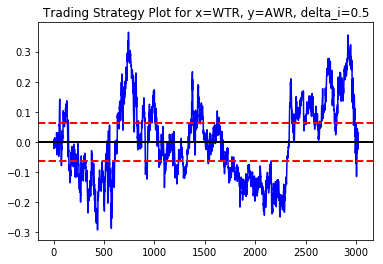

num_buys: 13
num_sells: 12


In [30]:
# Use the GenerateInfo class to generate equilibs and diffs
xWTR_yAWR_5 = GenerateInfo(wtr_log_prcs, awr_log_prcs, 0.5, "WTR", "AWR", "0.5")
xWTR_yAWR_5_equilibs = xWTR_yAWR_5.gen_equilib()
xWTR_yAWR_5_diffs = xWTR_yAWR_5.calc_preds_eps_diffs_bounds()[0]
# Use the NumSignals class to calculate the number of pairs of buy signals and
# the number of pairs of trade signals. Also plot the figure.
xWTR_yAWR_5_signals = NumSignals(xWTR_yAWR_5_diffs, xWTR_yAWR_5_equilibs, wtr_log_prcs, awr_log_prcs)
xWTR_yAWR_5.gen_plot()
print("num_buys:", xWTR_yAWR_5_signals.num_buys_sells()[0])
print("num_sells:", xWTR_yAWR_5_signals.num_buys_sells()[1])

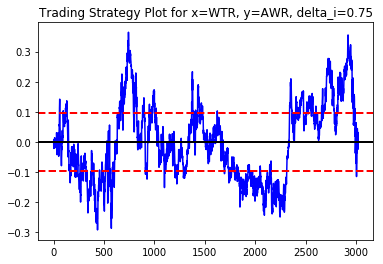

num_buys: 9
num_sells: 9


In [31]:
# Use the GenerateInfo class to generate equilibs and diffs
xWTR_yAWR_75 = GenerateInfo(wtr_log_prcs, awr_log_prcs, 0.75, "WTR", "AWR", "0.75")
xWTR_yAWR_75_equilibs = xWTR_yAWR_75.gen_equilib()
xWTR_yAWR_75_diffs = xWTR_yAWR_75.calc_preds_eps_diffs_bounds()[0]
# Use the NumSignals class to calculate the number of pairs of buy signals and
# the number of pairs of trade signals. Also plot the figure.
xWTR_yAWR_75_signals = NumSignals(xWTR_yAWR_75_diffs, xWTR_yAWR_75_equilibs, wtr_log_prcs, awr_log_prcs)
xWTR_yAWR_75.gen_plot()
print("num_buys:", xWTR_yAWR_75_signals.num_buys_sells()[0])
print("num_sells:", xWTR_yAWR_75_signals.num_buys_sells()[1])

### For the pair $\textbf{x = WTR}$ and $\textbf{y = AWR}$:

| $\delta_i$ | num_buys | num_sells |
|------------|----------|-----------|
| 0.25       | 24       | 25        |
| 0.5        | 13       | 12        |
| 0.75       | 9        | 9         |

### For the pair $\textbf{x = CTWS}$ and $\textbf{y = AWR}$ with $\delta_i \in \{0.25,0.5,0.75\}$:

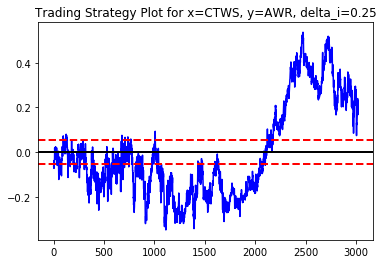

num_buys: 21
num_sells: 7


In [34]:
xCTWS_yAWR_25 = GenerateInfo(ctws_log_prcs, awr_log_prcs, 0.25, "CTWS", "AWR", "0.25")
xCTWS_yAWR_25_equilibs = xCTWS_yAWR_25.gen_equilib()
xCTWS_yAWR_25_diffs = xCTWS_yAWR_25.calc_preds_eps_diffs_bounds()[0]
# Use the NumSignals class to calculate the number of pairs of buy signals and
# the number of pairs of trade signals. Also plot the figure.
xCTWS_yAWR_25_signals = NumSignals(xCTWS_yAWR_25_diffs, xCTWS_yAWR_25_equilibs, ctws_log_prcs, awr_log_prcs)
xCTWS_yAWR_25.gen_plot()
print("num_buys:", xCTWS_yAWR_25_signals.num_buys_sells()[0])
print("num_sells:", xCTWS_yAWR_25_signals.num_buys_sells()[1])

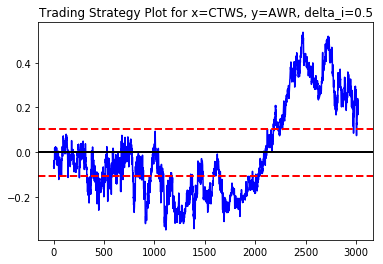

num_buys: 10
num_sells: 0


In [35]:
# Use the GenerateInfo class to generate equilibs and diffs
xCTWS_yAWR_5 = GenerateInfo(ctws_log_prcs, awr_log_prcs, 0.5, "CTWS", "AWR", "0.5")
xCTWS_yAWR_5_equilibs = xCTWS_yAWR_5.gen_equilib()
xCTWS_yAWR_5_diffs = xCTWS_yAWR_5.calc_preds_eps_diffs_bounds()[0]
# Use the NumSignals class to calculate the number of pairs of buy signals and
# the number of pairs of trade signals. Also plot the figure.
xCTWS_yAWR_5_signals = NumSignals(xCTWS_yAWR_5_diffs, xCTWS_yAWR_5_equilibs, ctws_log_prcs, awr_log_prcs)
xCTWS_yAWR_5.gen_plot()
print("num_buys:", xCTWS_yAWR_5_signals.num_buys_sells()[0])
print("num_sells:", xCTWS_yAWR_5_signals.num_buys_sells()[1])

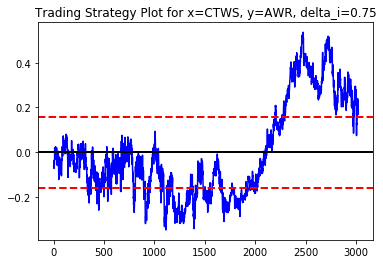

num_buys: 6
num_sells: 0


In [36]:
# Use the GenerateInfo class to generate equilibs and diffs
xCTWS_yAWR_75 = GenerateInfo(ctws_log_prcs, awr_log_prcs, 0.75, "CTWS", "AWR", "0.75")
xCTWS_yAWR_75_equilibs = xCTWS_yAWR_75.gen_equilib()
xCTWS_yAWR_75_diffs = xCTWS_yAWR_75.calc_preds_eps_diffs_bounds()[0]
# Use the NumSignals class to calculate the number of pairs of buy signals and
# the number of pairs of trade signals. Also plot the figure.
xCTWS_yAWR_75_signals = NumSignals(xCTWS_yAWR_75_diffs, xCTWS_yAWR_75_equilibs, ctws_log_prcs, awr_log_prcs)
xCTWS_yAWR_75.gen_plot()
print("num_buys:", xCTWS_yAWR_75_signals.num_buys_sells()[0])
print("num_sells:", xCTWS_yAWR_75_signals.num_buys_sells()[1])

### For the pair $\textbf{x = CTWS}$ and $\textbf{y = AWR}$:

| $\delta_i$ | num_buys | num_sells |
|------------|----------|-----------|
| 0.25       | 21       | 7         |
| 0.5        | 10       | 0         |
| 0.75       | 6        | 0         |

## Now that we've calculated the number of signals and visually represented them the last task we have is to:
- identify the first buy signal and first sell signal for each pair using the $\delta_1 = 0.25$ trading rule, calculating how many days each position is held for, and calculating the return on the trades

$\textbf{A NOTE:}$ since each signal is composed of a simultaneous long and short position, we calculate the 'long return' and 'short return' and simply add them to get the total return for the first buy signal, as well as for the first sell signal.

### For the pair x = CTWS and y = WTR:

In [37]:
firsts = NumSignals(xCTWS_yWTR_25_diffs, xCTWS_yWTR_25_equilibs, ctws_log_prcs, wtr_log_prcs)
first_buy = firsts.find_signal_indices('buy')
first_buy
first_sell = firsts.find_signal_indices('sell')
first_sell   
print("The number of days that the first ", first_buy[0], " position is held is ", 
      first_buy[2]-first_buy[1], ", returning ", round(firsts.calc_return('buy'),6), "%", sep="")
print("The number of days that the first ", first_sell[0], " position is held is ", 
      first_sell[2]-first_sell[1], ", returning ", round(firsts.calc_return('sell'),6), "%", sep="")

The number of days that the first buy position is held is 151, returning 11.053421%
The number of days that the first sell position is held is 11, returning 5.057266%


- From this, we can deduce that the relative price system for CTWS and WTR stock was in dis-equilibrium for a long period of time for the first buy: over half a year ($\textbf{151}$ trading days)! This was by far the longest signal duration for any of the pairs of stocks and the first signals.
- For the buy we went short on CTWS (i.e. CTWS was over-priced) and we went long on WTR (i.e. WTR was under-priced). Once the market was 'correctly pricing' these stocks relative to one another the system was back to equilibrium and we closed out our position, returning $\textbf{11.053421%}$.
- The first sell signal for this pair only lasted for $\textbf{11}$ trading days, so the system of relative prices corrected much more quickly than for the first buy.
- For the sell we went long on CTWS (i.e. CTWS was under-priced) and we went short on WTR (i.e. WTR was over-priced). Once the market was 'correctly pricing' these stocks relative to one another the system was back to equilibrium and we closed out our position, returning $\textbf{5.057266%}$.

### For the pair x = WTR and y = AWR

In [38]:
firsts = NumSignals(xWTR_yAWR_25_diffs, xWTR_yAWR_25_equilibs, wtr_log_prcs, awr_log_prcs)
first_buy = firsts.find_signal_indices('buy')
first_buy
first_sell = firsts.find_signal_indices('sell')
first_sell   
print("The number of days that the first ", first_buy[0], " position is held is ", 
      first_buy[2]-first_buy[1], ", returning ", round(firsts.calc_return('buy'),6), "%", sep="")
print("The number of days that the first ", first_sell[0], " position is held is ", 
      first_sell[2]-first_sell[1], ", returning ", round(firsts.calc_return('sell'),6), "%", sep="")

The number of days that the first buy position is held is 3, returning 1.503591%
The number of days that the first sell position is held is 12, returning 5.971284%


- From this, we can see that the relative price system for WTR and AWR stock was in dis-equilibrium for a very short period of time for the first buy, only $\textbf{3}$ trading days.
- For the buy we went short on WTR (i.e. WTR was over-priced) and we went long on AWR (i.e. AWR was under-priced). Once the market was 'correctly pricing' these stocks relative to one another the system was back to equilibrium and we closed out our position, returning $\textbf{1.503591%}$.
- The first sell signal for this pair lasted for $\textbf{12}$ trading days, so the system of relative prices for these stocks took a bit longer to correct than it did for the first buy.
- For the sell we went long on WTR (i.e. WTR was under-priced) and we went short on AWR (i.e. AWR was over-priced). Once the market was 'correctly pricing' these stocks relative to one another the system was back to equilibrium and we closed out our position, returning $\textbf{5.971284%}$.

### For the pair x = CTWS and y = AWR

In [39]:
firsts = NumSignals(xCTWS_yAWR_25_diffs, xCTWS_yAWR_25_equilibs, ctws_log_prcs, awr_log_prcs)
first_buy = firsts.find_signal_indices('buy')
first_buy
first_sell = firsts.find_signal_indices('sell')
first_sell   
print("The number of days that the first ", first_buy[0], " position is held is ", 
      first_buy[2]-first_buy[1], ", returning ", round(firsts.calc_return('buy'),6), "%", sep="")
print("The number of days that the first ", first_sell[0], " position is held is ", 
      first_sell[2]-first_sell[1], ", returning ", round(firsts.calc_return('sell'),6), "%", sep="")

The number of days that the first buy position is held is 10, returning 3.823205%
The number of days that the first sell position is held is 11, returning 3.506034%


- From this, we can see that the relative price system for CTWS and AWR stock was in dis-equilibrium for $\textbf{10}$ trading days for the first buy.
- For the buy we went short on CTWS (i.e. CTWS was over-priced) and we went long on AWR (i.e. AWR was under-priced). Once the market was 'correctly pricing' these stocks relative to one another the system was back to equilibrium and we closed out our position and returning $\textbf{3.823205%}$.
- The first sell signal for this pair only lasted for $\textbf{11}$ trading days, so the system of relative prices correctly much more quickly than for the first buy.
- For the sell we went long on CTWS (i.e. CTWS was under-priced) and we went short on AWR (i.e. AWR was over-priced). Once the market was 'correctly pricing' these stocks relative to one another the system was back to equilibrium and we closed out our position and returning $\textbf{3.506034%}$.

# This was a super fun replcation project and I learned a ton!!  
-- Jared